# 01. Importing necessary libraries

In [1]:
import pandas as pd#used to load, process, and manipulate the dataset.
import numpy as np#It provides support for arrays and matrices, along with mathematical functions.
import tensorflow as tf#An open-source deep learning framework used to build and train neural networks.
from tensorflow.keras.preprocessing.text import Tokenizer#Tokenizer: Used to convert text to sequences of integers.
#pad_sequences: Used to ensure all sequences in a list have the same length by padding shorter sequences.
from tensorflow.keras.preprocessing.sequence import pad_sequences
#Sequential: A linear stack of layers for building the neural network.
from tensorflow.keras.models import Sequential
#Embedding: A layer to convert input sequences into dense vectors of fixed size.
#LSTM: Long Short-Term Memory layer, a type of RNN used for learning long-term dependencies.
#Dense: A fully connected layer.
#Dropout: A regularization layer to prevent overfitting by randomly setting a fraction of input units to 0 at each update during training.
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
#train_test_split: Used to split the dataset into training and testing sets.
from sklearn.model_selection import train_test_split
#accuracy_score: To compute the accuracy of the model.
#classification_report: To generate a detailed report on the precision, recall, f1-score, and support.
from sklearn.metrics import accuracy_score, classification_report
# plotting library used for data visualization.
import matplotlib.pyplot as plt
#data visualization library based on Matplotlib that provides a high-level interface for drawing attractive and informative statistical graphics.
import seaborn as sns
#The Natural Language Toolkit, a library for working with human language data (text).
import nltk
#stopwords: Common words (like 'the', 'and', etc.) that are usually removed from text data during preprocessing.
from nltk.corpus import stopwords
#The regular expression library in Python, used for text processing and pattern matching.
import re

#02. Load the dataset

In [19]:
#df, which stands for DataFrame
#This line of code uses the pandas library's read_csv function to read the contents of the file named IMDB Dataset.csv.
df = pd.read_csv('IMDB Dataset.csv')
#The df.head() function displays the first 5 rows of the DataFrame, providing a quick look at the data's structure and content.
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


#03. Preprocessing the data

In [3]:
#This line downloads the 'stopwords' dataset from the Natural Language Toolkit (NLTK). Stopwords are commonly used words
#(like "and", "the", "is") that are often removed from text data because they don't carry significant meaning in the context of text analysis.
nltk.download('stopwords')
#stop_words will be used to filter out these common words from the text data.
#nglish stopwords using stopwords.words('english') from the NLTK library and converts it into a set for faster membership testing.
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
  #This line converts all the characters in the text to lowercase.
    text = text.lower()
  #This line uses the re.sub function from the re (regular expression) module to replace occurrences of HTML line break tags (<br />) with a space.
    text = re.sub(r'<br />', ' ', text)
  #This line removes all characters from the text that are not alphabetic (a-z, A-Z) or whitespace.
    text = re.sub(r'[^a-zA-Z\s]', '', text)
  #This line removes common words (stopwords) from the text.
    text = ' '.join([word for word in text.split() if word not in stop_words])
  #This line returns the cleaned and processed version of the input text.
    return text
#This part of the code accesses the 'review' column of the DataFrame df.
#The apply() method is used to apply a function along an axis of the DataFrame.
df['review'] = df['review'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#04. Tokenize and pad the text data

In [4]:

#This line creates an instance of the Tokenizer class from Keras.
#num_words=5000: Limits the tokenizer to only consider the top 5000 most frequent words in the dataset.
#oov_token='<OOV>': Specifies a token (<OOV>) to represent any words that are not in the top 5000 words.
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
#This line fits the tokenizer on the 'review' column of the DataFrame df.
#fit_on_texts(): Analyzes the text data and builds the vocabulary index based on the words in the 'review' column.
tokenizer.fit_on_texts(df['review'])
#This line converts the text data into sequences of integers based on the tokenizer’s vocabulary.
sequences = tokenizer.texts_to_sequences(df['review'])
#sequences: The list of sequences (integer lists) to be padded.
#padding='post': Specifies that padding should be added at the end of the sequences. This means that if the sequence is shorter than maxlen, zeros will be added at the end.
#maxlen=200: Sets the maximum length of the sequences. If a sequence is longer than this length, it will be truncated. If it is shorter, it will be padded to this length.
padded_sequences = pad_sequences(sequences, padding='post', maxlen=200)

#05. Prepare the labels

In [5]:
#This line converts the textual sentiment labels in the 'sentiment' column of the DataFrame df into numerical values.
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
#This line extracts the processed sentiment labels from the DataFrame and stores them in a NumPy array called labels.
labels = df['sentiment'].values

#06. Split the data into training and testing sets

In [6]:
#This line splits the dataset into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

#07. Create the LSTM model

In [7]:
#Initializes a Sequential model. The Sequential class in Keras is a linear stack of layers where you can simply add layers one after the other.
model = Sequential([
    #Converts integer sequences into dense vector representations.
    Embedding(input_dim=5000, output_dim=64, input_length=200),
    #Applies an LSTM (Long Short-Term Memory) layer to the input data.
    LSTM(64, return_sequences=True),
    #Applies dropout regularization to prevent overfitting.
    Dropout(0.5),
    #Adds another LSTM layer.
    LSTM(64),
    #Adds dropout regularization after the second LSTM layer to further prevent overfitting.
    Dropout(0.5),
    #Number of output units. For binary classification, we only need one output unit.
    #activation='sigmoid': Uses the sigmoid activation function, which outputs a value between 0 and 1, suitable for binary classification problems.
    Dense(1, activation='sigmoid')
])
#Configures the model for training.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#08. Train the model

In [8]:
#model.fit initiates the training process with the specified parameters.
#X_train and y_train are used to train the model.
#Defines how many times the model will iterate over the entire training data.
#Specifies the number of samples processed before updating the model weights.
#Evaluates the model on unseen test data to monitor its performance during training.
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
625/625 [==============================] - 234s 367ms/step - loss: 0.6944 - accuracy: 0.5131 - val_loss: 0.6930 - val_accuracy: 0.4974
Epoch 2/5
625/625 [==============================] - 221s 354ms/step - loss: 0.6939 - accuracy: 0.5081 - val_loss: 0.6930 - val_accuracy: 0.4961
Epoch 3/5
625/625 [==============================] - 219s 350ms/step - loss: 0.6555 - accuracy: 0.5872 - val_loss: 0.6922 - val_accuracy: 0.5070
Epoch 4/5
625/625 [==============================] - 215s 344ms/step - loss: 0.6905 - accuracy: 0.5045 - val_loss: 0.6864 - val_accuracy: 0.4961
Epoch 5/5
625/625 [==============================] - 218s 349ms/step - loss: 0.6702 - accuracy: 0.5627 - val_loss: 0.6371 - val_accuracy: 0.6366


#09. Evaluate the model

In [9]:
#This line evaluates the performance of the trained model on the test data.
loss, accuracy = model.evaluate(X_test, y_test)
#This line prints the test accuracy in a human-readable format.
print(f'Test Accuracy: {accuracy*100:.2f}%')

313/313 [==============================] - 23s 74ms/step - loss: 0.6371 - accuracy: 0.6366
Test Accuracy: 63.66%


#10. Make predictions

In [10]:
#This method generates predictions from the trained model based on the input data (X_test).
#model.predict(X_test) > 0.5 Converts the predicted probabilities into binary class labels.
y_pred = (model.predict(X_test) > 0.5).astype("int32")

313/313 [==============================] - 24s 71ms/step


#11. Classification report

In [11]:
#produces a detailed report of precision, recall, F1-score, and support for each class, as well as overall accuracy.
#print(...) displays this report in the console, allowing you to evaluate the model’s performance comprehensively.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.36      0.49      4961
           1       0.59      0.91      0.72      5039

    accuracy                           0.64     10000
   macro avg       0.69      0.63      0.61     10000
weighted avg       0.69      0.64      0.61     10000



#12. Visualize the results

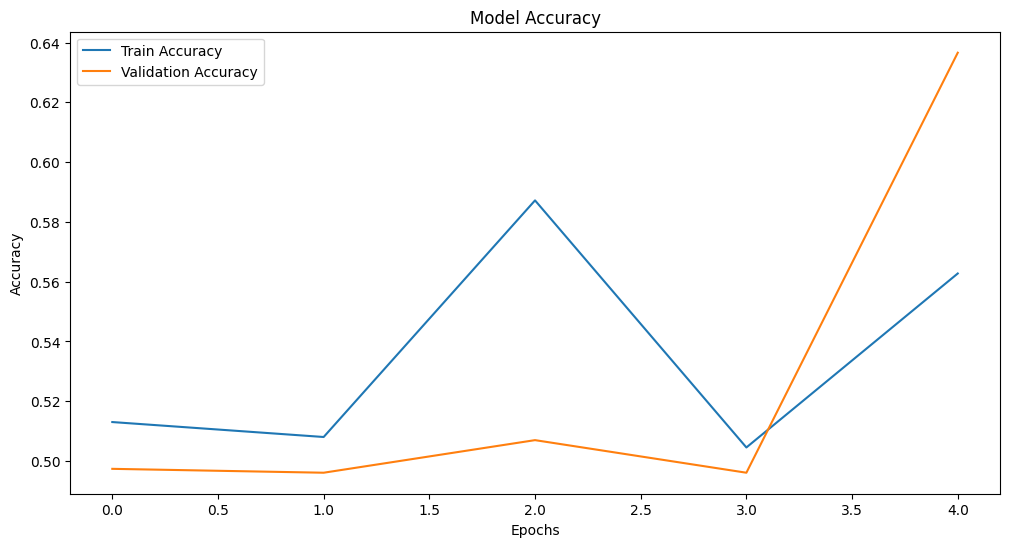

In [12]:
# Plot accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#13. Plot loss

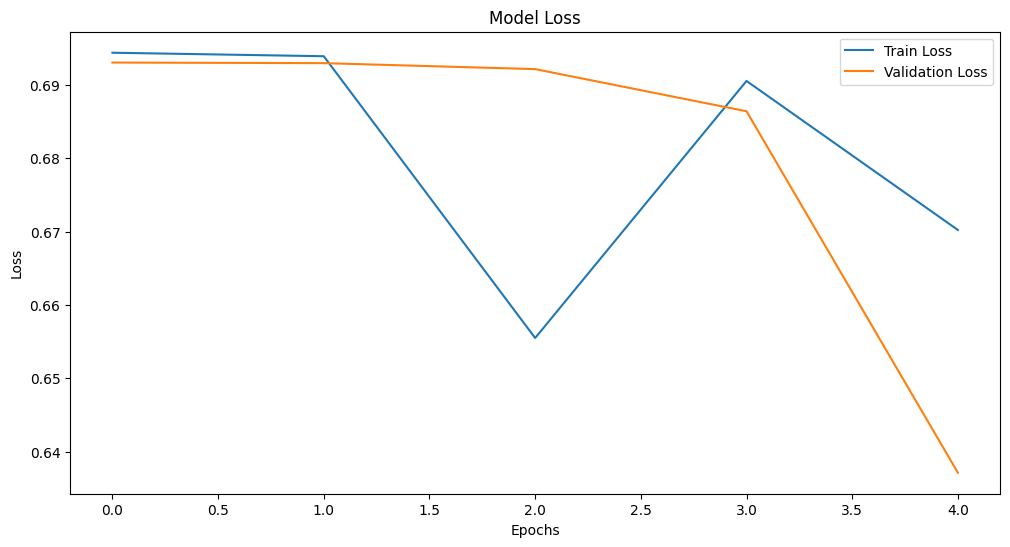

In [13]:

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#14. Function to preprocess and predict sentiment of new reviews

In [14]:

def predict_sentiment(reviews):
    processed_reviews = [preprocess_text(review) for review in reviews]
    sequences = tokenizer.texts_to_sequences(processed_reviews)
    padded_sequences = pad_sequences(sequences, padding='post', maxlen=200)
    predictions = (model.predict(padded_sequences) > 0.5).astype("int32")
    sentiment = ['positive' if pred == 1 else 'negative' for pred in predictions]
    return sentiment


#15. Test the model with new reviews

In [15]:

test_reviews = [
    "The movie was fantastic! I really enjoyed it.",
    "It was a terrible movie. I will not recommend it to anyone.",
    "The plot was a bit slow, but overall it was a good film.",
    "I absolutely loved the cinematography. Brilliant work!",
    "The acting was mediocre and the storyline was predictable."
]

predicted_sentiments = predict_sentiment(test_reviews)

1/1 [==============================] - 0s 135ms/step


#16. Print the results

In [16]:
for review, sentiment in zip(test_reviews, predicted_sentiments):
    print(f"Review: {review}\nPredicted Sentiment: {sentiment}\n")

Review: The movie was fantastic! I really enjoyed it.
Predicted Sentiment: positive

Review: It was a terrible movie. I will not recommend it to anyone.
Predicted Sentiment: negative

Review: The plot was a bit slow, but overall it was a good film.
Predicted Sentiment: positive

Review: I absolutely loved the cinematography. Brilliant work!
Predicted Sentiment: positive

Review: The acting was mediocre and the storyline was predictable.
Predicted Sentiment: positive

